In [8]:
import yt
import numpy as np
from matplotlib import pylab
from math import pi
import unyt

In [9]:
from yt.funcs import mylog

# only critical log messages are printed
mylog.setLevel(50)

# the default log level is 20, which shows warnings and info messages
# mylog.setLevel(20)

In [10]:
ts = yt.load('DD????/output_????')

# BH particle filter

In [12]:
@yt.particle_filter('p3_bh', ['creation_time', 'particle_mass', 'particle_type'])
def p3_bh(pfilter, data):
    return (data['particle_type'] == 1) & (data['creation_time'] > 0) & \
        (data['particle_mass'].in_units('Msun') > 1e-3)

# Find BH rate for each ds in ts
Sometimes `unyt` just fails, gotta find alternatives

In [13]:
unyt.gravitational_constant

unyt_quantity(6.67408e-11, 'm**3/(kg*s**2)')

In [110]:
# convert unyt.gravitational_constant in unyt to yt units
from yt.units import kg, m, s
G = unyt.gravitational_constant.v * m**3/(kg*s**2)
G

6.67408e-11 m**3/(kg*s**2)

In [ ]:
# when using yt.units instead of unyt
from yt.units import kg, m, s
def bondi_hoyle_rate(rho, cs, vrel, mbh, boost=1):
    vmag = ((vrel**2).sum())**0.5
    G = unyt.gravitational_constant.v * m**3/(kg*s**2)
    return boost * pi * rho * G**2 * mbh**2 / max(vmag, cs)**3

def bondi_radius(cs, mbh):
    G = unyt.gravitational_constant.v * m**3/(kg*s**2)
    return 2 * G * mbh / cs**2

In [14]:
# when using unyt
def bondi_hoyle_rate(rho, cs, vrel, mbh, boost=1):
    vmag = ((vrel**2).sum())**0.5
    return boost * pi * rho * unyt.gravitational_constant**2 * mbh**2 / max(vmag, cs)**3

def bondi_radius(cs, mbh):
    return 2 * unyt.gravitational_constant * mbh / cs**2

In [15]:
# create dicts to store the BH rate and Bondi radius of each BH in each ds of the ts
ts_bh_rate = {}
ts_bondi_r = {}
for j in range(len(ts)):
    ds = ts[j] # MUST save to another variable for the particle filter to work
    ds.add_particle_filter('p3_bh')
    ad = ds.all_data() # using ts[j] do NOT work because the particle filter isn't saved
    bh_id = ad['p3_bh', 'particle_index']
    
    # dicts to store the BH rate and Bondi radius of each BH in the current ds
    ds_bh_rate = {}
    ds_bondi_r = {}

    for i in range(len(bh_id)): # loop over each BH found in ds
        # calculate BH rate for each BH
        pos = ad['p3_bh', 'particle_position'][i]
        mass = ad['p3_bh', 'particle_mass'][i]
        vbh = ad['p3_bh', 'particle_velocity'][i]
        # find quantities at the cell
        rho, cs, vx, vy, vz, dx = ds.find_field_values_at_point(['density', 'sound_speed', 'velocity_x', 'velocity_y', 'velocity_z', 'dx'], pos)
        vrel = ds.arr([vx-vbh[0], vy-vbh[1], vz-vbh[2]]) # find relative velocity
        # the initial values are in a list, but the resolved values are NOT!!!
        mbh_dt0 = bondi_hoyle_rate(rho, cs, vrel, mass)[0].to('Msun/yr') # initial BH rate
        #rb0 = bondi_radius(cs, mass)[0].to('pc') # initial Bondi radius
        rb0 = bondi_radius(cs, mass)[0].to('pc') * 10000 # JUST FOR TESTING!!! # initial Bondi radius
        dx0 = dx[0].to('pc') # initial cell width

        # Only iterate if the Bondi radius is larger than the cell width, that is, the Bondi sphere is resolved
        tolerance = 0.05  # Stop iterating when the r_Bondi changes less than this percentage
        change = 1e20  # Arbitrary large number to go into the first loop
        rb_last = rb0.copy() # rb0 is a list of 1 item
        rb = rb0.copy() # rb0 is a list of 1 item
        mbh_dt = mbh_dt0.copy() # remember initial BH rate in case the Bondi sphere is NOT resolved
        if dx0 < rb0:
            while change > tolerance:
                try:
                    sp = ds.sphere(pos, rb) # make a sphere with the initial Bondi radius
                # when YTSphereTooSmall error arises, break out of the while loop, use the last results, and continue to the next BH
                except:
                    break
                # find updated quantities from averaging within the Bondi radius
                rhobar, csbar, vxbar, vybar, vzbar = \
                    sp.quantities.weighted_average_quantity(['density', 'sound_speed', 'velocity_x', 'velocity_y', 'velocity_z'],
                                                            weight=('gas', 'mass'))
                vrelbar = ds.arr([vxbar-vbh[0], vybar-vbh[1], vzbar-vbh[2]])
                # update BH rate and Bondi radius with new quantities
                mbh_dt = bondi_hoyle_rate(rhobar, csbar, vrelbar, mass)
                rb = bondi_radius(csbar, mass)
                change = abs(rb - rb_last) / rb_last # find the change % between new and old Bondi radius
                rb_last = rb.copy() # to remember the prior updated Bondi radius for the next loop
            print(i, 'Resolved Bondi-Hoyle rate = %s, resolved Bondi radius = %s' % (mbh_dt.to('Msun/yr'), rb_last.to('pc')))

        else:
            print(i, 'Bondi radius (%s) in cell is smaller than resolution element (%s), Bondi-Hoyle rate = %s' % (rb0.to('pc'), dx0.to('pc'), mbh_dt.to('Msun/yr')))

        # add results to dict with keys as BH indices
        ds_bondi_r[int(bh_id[i])] = rb_last.to('pc') # use this instead of rb because rb could be too small of a sphere radius
        ds_bh_rate[int(bh_id[i])] = mbh_dt.to('Msun/yr')
    
    # add dicts of BH rates and Bondi radius of each ds to the ts dict, with keys as ds # in the ts
    ts_bondi_r[j] = ds_bondi_r
    ts_bh_rate[j] = ds_bh_rate

Parsing Hierarchy : 100%|██████████| 767/767 [00:00<00:00, 19556.42it/s]


0 Resolved Bondi-Hoyle rate = 6.310185048012036e-14 Msun/yr, resolved Bondi radius = 0.0011934248157714922 pc
1 Resolved Bondi-Hoyle rate = 6.359983978485424e-14 Msun/yr, resolved Bondi radius = 0.001184531482466464 pc
2 Resolved Bondi-Hoyle rate = 3.7440769778618565e-14 Msun/yr, resolved Bondi radius = 0.0011846772847086701 pc
3 Resolved Bondi-Hoyle rate = 1.1336540668951212e-13 Msun/yr, resolved Bondi radius = 0.009117688088934324 pc
4 Bondi radius (12.316863060157965 pc) in cell is smaller than resolution element (19.887380767816182 pc), Bondi-Hoyle rate = 2.055519399641243e-14 Msun/yr
5 Resolved Bondi-Hoyle rate = 3.228565239872782e-12 Msun/yr, resolved Bondi radius = 0.00935099112554985 pc
6 Resolved Bondi-Hoyle rate = 8.952357390571785e-13 Msun/yr, resolved Bondi radius = 0.004898143600249913 pc
7 Resolved Bondi-Hoyle rate = 1.5537293900678964e-13 Msun/yr, resolved Bondi radius = 0.0046564809290140854 pc
8 Resolved Bondi-Hoyle rate = 9.639188122566008e-13 Msun/yr, resolved Bondi 

Parsing Hierarchy :   0%|          | 0/754 [00:00<?, ?it/s]

12 Resolved Bondi-Hoyle rate = 2.95321108124811e-11 Msun/yr, resolved Bondi radius = 0.012711813729687091 pc
13 Resolved Bondi-Hoyle rate = 5.806350766703019e-13 Msun/yr, resolved Bondi radius = 0.007536136558637548 pc
14 Resolved Bondi-Hoyle rate = 3.625285869418641e-14 Msun/yr, resolved Bondi radius = 0.004576717894831833 pc
15 Resolved Bondi-Hoyle rate = 2.276626055837733e-13 Msun/yr, resolved Bondi radius = 0.008177965959418668 pc
16 Resolved Bondi-Hoyle rate = 1.9028275508316324e-12 Msun/yr, resolved Bondi radius = 0.004734996168790387 pc


Parsing Hierarchy : 100%|██████████| 754/754 [00:00<00:00, 20870.63it/s]


0 Resolved Bondi-Hoyle rate = 4.0739328800246465e-14 Msun/yr, resolved Bondi radius = 0.004738854194535235 pc
1 Resolved Bondi-Hoyle rate = 2.1548143188758694e-13 Msun/yr, resolved Bondi radius = 0.008454654482016394 pc
2 Bondi radius (11.80323066712416 pc) in cell is smaller than resolution element (19.918383238495807 pc), Bondi-Hoyle rate = 1.86278852237363e-14 Msun/yr
3 Resolved Bondi-Hoyle rate = 1.2840731175353363e-13 Msun/yr, resolved Bondi radius = 0.009211101096721132 pc
4 Resolved Bondi-Hoyle rate = 8.828621681327725e-13 Msun/yr, resolved Bondi radius = 0.004852365623039436 pc
5 Resolved Bondi-Hoyle rate = 3.2692271831527666e-12 Msun/yr, resolved Bondi radius = 0.009359491063311099 pc
6 Resolved Bondi-Hoyle rate = 3.5074892796845274e-14 Msun/yr, resolved Bondi radius = 0.0011247177181445064 pc
7 Resolved Bondi-Hoyle rate = 2.300929651437892e-13 Msun/yr, resolved Bondi radius = 0.008988579032608003 pc
8 Resolved Bondi-Hoyle rate = 5.880853327777092e-14 Msun/yr, resolved Bondi r

Parsing Hierarchy :   0%|          | 0/792 [00:00<?, ?it/s]

12 Resolved Bondi-Hoyle rate = 1.568795110894393e-13 Msun/yr, resolved Bondi radius = 0.004679976310856769 pc
13 Resolved Bondi-Hoyle rate = 1.675177225018555e-13 Msun/yr, resolved Bondi radius = 0.006538636240061707 pc
14 Resolved Bondi-Hoyle rate = 2.408061489264576e-12 Msun/yr, resolved Bondi radius = 0.004644716863359026 pc
15 Resolved Bondi-Hoyle rate = 2.5419023545009857e-11 Msun/yr, resolved Bondi radius = 0.012744057325538674 pc
16 Resolved Bondi-Hoyle rate = 5.15680643287065e-13 Msun/yr, resolved Bondi radius = 0.007361676042292643 pc


Parsing Hierarchy : 100%|██████████| 792/792 [00:00<00:00, 23191.07it/s]


0 Resolved Bondi-Hoyle rate = 1.537544075086943e-13 Msun/yr, resolved Bondi radius = 0.004653962434654529 pc
1 Resolved Bondi-Hoyle rate = 9.564126924437805e-13 Msun/yr, resolved Bondi radius = 0.008204920587469605 pc
2 Resolved Bondi-Hoyle rate = 1.690728600102326e-13 Msun/yr, resolved Bondi radius = 0.0065096746614413505 pc
3 Resolved Bondi-Hoyle rate = 2.523171315311919e-12 Msun/yr, resolved Bondi radius = 0.00462500828634304 pc
4 Resolved Bondi-Hoyle rate = 2.1904775395542298e-11 Msun/yr, resolved Bondi radius = 0.012659143113462822 pc
5 Resolved Bondi-Hoyle rate = 5.113118346478791e-13 Msun/yr, resolved Bondi radius = 0.007278999879880351 pc
6 Resolved Bondi-Hoyle rate = 1.4627974349471046e-13 Msun/yr, resolved Bondi radius = 0.009323495513748182 pc
7 Bondi radius (12.156853566903902 pc) in cell is smaller than resolution element (19.949361629232772 pc), Bondi-Hoyle rate = 2.0681036481442154e-14 Msun/yr
8 Resolved Bondi-Hoyle rate = 8.818885237124447e-13 Msun/yr, resolved Bondi ra

Parsing Hierarchy : 100%|██████████| 771/771 [00:00<00:00, 23019.71it/s]


16 Resolved Bondi-Hoyle rate = 4.232325085858629e-14 Msun/yr, resolved Bondi radius = 0.004785191927540853 pc
0 Resolved Bondi-Hoyle rate = 2.5190927991549617e-13 Msun/yr, resolved Bondi radius = 0.00791005611283879 pc
1 Resolved Bondi-Hoyle rate = 4.060310047600383e-14 Msun/yr, resolved Bondi radius = 0.004884383051804136 pc
2 Resolved Bondi-Hoyle rate = 2.556648654056406e-13 Msun/yr, resolved Bondi radius = 0.008795862282615256 pc
3 Resolved Bondi-Hoyle rate = 6.028460261662321e-14 Msun/yr, resolved Bondi radius = 0.001207548039046904 pc
4 Resolved Bondi-Hoyle rate = 5.61421417774514e-14 Msun/yr, resolved Bondi radius = 0.001169983133123631 pc
5 Resolved Bondi-Hoyle rate = 1.5773111256557778e-13 Msun/yr, resolved Bondi radius = 0.004642956576728274 pc
6 Resolved Bondi-Hoyle rate = 1.7453739298214422e-13 Msun/yr, resolved Bondi radius = 0.006438486813796907 pc
7 Resolved Bondi-Hoyle rate = 2.4487828897947776e-12 Msun/yr, resolved Bondi radius = 0.0046814285982505 pc
8 Resolved Bondi-H

Parsing Hierarchy :   0%|          | 0/773 [00:00<?, ?it/s]

12 Resolved Bondi-Hoyle rate = 8.734777347780907e-13 Msun/yr, resolved Bondi radius = 0.004772124265315284 pc
13 Resolved Bondi-Hoyle rate = 3.2794206288290055e-12 Msun/yr, resolved Bondi radius = 0.009390118358695083 pc
14 Resolved Bondi-Hoyle rate = 9.547067908823171e-13 Msun/yr, resolved Bondi radius = 0.008238178264311885 pc
15 Resolved Bondi-Hoyle rate = 9.688519926418673e-15 Msun/yr, resolved Bondi radius = 0.004181707457201786 pc
16 Resolved Bondi-Hoyle rate = 3.667365027879178e-14 Msun/yr, resolved Bondi radius = 0.0011185883083118628 pc


Parsing Hierarchy : 100%|██████████| 773/773 [00:00<00:00, 22445.58it/s]


0 Resolved Bondi-Hoyle rate = 4.1357848944427926e-14 Msun/yr, resolved Bondi radius = 0.004581847347382223 pc
1 Resolved Bondi-Hoyle rate = 2.454066111582933e-13 Msun/yr, resolved Bondi radius = 0.008884490859770902 pc
2 Resolved Bondi-Hoyle rate = 1.6124915793583815e-13 Msun/yr, resolved Bondi radius = 0.0046326724802455204 pc
3 Resolved Bondi-Hoyle rate = 9.593566152353713e-13 Msun/yr, resolved Bondi radius = 0.008276059288760811 pc
4 Resolved Bondi-Hoyle rate = 1.7684782694810244e-13 Msun/yr, resolved Bondi radius = 0.006378062906842822 pc
5 Resolved Bondi-Hoyle rate = 2.446665875167212e-12 Msun/yr, resolved Bondi radius = 0.0048104234526234555 pc
6 Resolved Bondi-Hoyle rate = 2.1798807880640844e-11 Msun/yr, resolved Bondi radius = 0.012771112368901985 pc
7 Resolved Bondi-Hoyle rate = 4.094547050903001e-13 Msun/yr, resolved Bondi radius = 0.007267691385778645 pc
8 Bondi radius (11.961509044048626 pc) in cell is smaller than resolution element (20.01124702616393 pc), Bondi-Hoyle rate

Parsing Hierarchy : 100%|██████████| 777/777 [00:00<00:00, 22632.39it/s]

12 Resolved Bondi-Hoyle rate = 4.966249609541485e-15 Msun/yr, resolved Bondi radius = 0.00393694813346194 pc
13 Resolved Bondi-Hoyle rate = 2.5878060176856716e-13 Msun/yr, resolved Bondi radius = 0.008568605104353541 pc
14 Resolved Bondi-Hoyle rate = 1.9233305815499457e-13 Msun/yr, resolved Bondi radius = 0.002487895304749456 pc
15 Resolved Bondi-Hoyle rate = 1.7289553641807078e-13 Msun/yr, resolved Bondi radius = 0.0024057722584492334 pc
16 Resolved Bondi-Hoyle rate = 9.249828547693232e-14 Msun/yr, resolved Bondi radius = 0.0020910894164667803 pc


0 Resolved Bondi-Hoyle rate = 2.6643897573500545e-13 Msun/yr, resolved Bondi radius = 0.009118014773880849 pc
1 Resolved Bondi-Hoyle rate = 4.581682005235454e-14 Msun/yr, resolved Bondi radius = 0.00402585579174694 pc
2 Resolved Bondi-Hoyle rate = 2.7552957138684923e-13 Msun/yr, resolved Bondi radius = 0.0030795363470034255 pc
3 Resolved Bondi-Hoyle rate = 2.6252177570711456e-13 Msun/yr, resolved Bondi radius = 0.002992897617979415 pc
4 Resolved Bondi-Hoyle rate = 8.994730276402469e-14 Msun/yr, resolved Bondi radius = 0.0026073944299229187 pc
5 Resolved Bondi-Hoyle rate = 9.415347333736572e-13 Msun/yr, resolved Bondi radius = 0.008291979981260937 pc
6 Resolved Bondi-Hoyle rate = 1.9559542788879296e-13 Msun/yr, resolved Bondi radius = 0.00617205757594527 pc
7 Resolved Bondi-Hoyle rate = 1.5711468055723253e-13 Msun/yr, resolved Bondi radius = 0.00462340202710289 pc
8 Resolved Bondi-Hoyle rate = 2.284422408545487e-12 Msun/yr, resolved Bondi radius = 0.004939611385109991 pc
9 Resolved Bond

In [16]:
ts_bh_rate

{0: {738541: unyt_quantity(6.31018505e-14, 'Msun/yr'),
  738850: unyt_quantity(6.35998398e-14, 'Msun/yr'),
  738899: unyt_quantity(3.74407698e-14, 'Msun/yr'),
  738896: unyt_quantity(1.13365407e-13, 'Msun/yr'),
  738856: unyt_quantity(2.0555194e-14, 'Msun/yr'),
  738871: unyt_quantity(3.22856524e-12, 'Msun/yr'),
  738519: unyt_quantity(8.95235739e-13, 'Msun/yr'),
  738534: unyt_quantity(1.55372939e-13, 'Msun/yr'),
  738863: unyt_quantity(9.63918812e-13, 'Msun/yr'),
  738876: unyt_quantity(2.18511301e-13, 'Msun/yr'),
  738875: unyt_quantity(1.67719975e-13, 'Msun/yr'),
  738532: unyt_quantity(1.33814821e-14, 'Msun/yr'),
  738527: unyt_quantity(2.95321108e-11, 'Msun/yr'),
  738866: unyt_quantity(5.80635077e-13, 'Msun/yr'),
  738543: unyt_quantity(3.62528587e-14, 'Msun/yr'),
  738523: unyt_quantity(2.27662606e-13, 'Msun/yr'),
  738514: unyt_quantity(1.90282755e-12, 'Msun/yr')},
 1: {738543: unyt_quantity(4.07393288e-14, 'Msun/yr'),
  738523: unyt_quantity(2.15481432e-13, 'Msun/yr'),
  7388

# Calculate mass after accretion
Some black holes may form at different timesteps in the simulation. Therefore, to account for the inconsistent number of black holes at different snapshots, I will create a system as follows:
- create a list of the timesteps of all the snapshots
- remember the masses BEFORE accretion of all the BH IDs in all snapshots in a dict
- create an empty dict to contain the computed mass after accretion
    - keys as the BH IDs of the LAST snapshot because these are the most comprehensive IDs
    - starting from the beginning of the entire simulation, if a BH ID in that snapshot is NOT in the LAST BH ID list, its mass in that snapshot will be 0
- starting from snapshot j, given the mass at snapshot j-1, and the timesteps between snapshots --> compute the mass after accretion at snapshot j
    - if the mass at snapshot j-1 is 0:
        - continue to snapshot j, until reaching a non-0 mass
        - if performing the computation on mass of 0, the subsequent masses will also be 0!
        - mass = 0 also means BH rate = 0
    - else:
        - compute the mass after accretion at snapshot j
        - add the accreted mass at snapshot j to the list
- compute the final mass of each BH by iterating over all snapshots

**The order in which the arrays (`particle_position`, `particle_index`, or any other particle field) are sorted are the same.**

In [200]:
# make a list of the timesteps of all snapshots (timeseries)
timesteps = []
for ds in ts:
    timesteps.append(ds.current_time.in_units('Myr'))
timesteps

[unyt_quantity(401.51503415, 'Myr'),
 unyt_quantity(402.45391145, 'Myr'),
 unyt_quantity(403.39278875, 'Myr'),
 unyt_quantity(404.33166605, 'Myr'),
 unyt_quantity(405.27054335, 'Myr'),
 unyt_quantity(406.20942065, 'Myr')]

In [19]:
ts_b4_mass = {} # contains mass before accretion
ts_accreted_m = {} # contains mass after accretion

# make a dict of the mass before accretion of every dataset in timeseries
for j in range(len(ts)):
    ds = ts[j] # MUST save to another variable for the particle filter to work
    ds.add_particle_filter('p3_bh')
    ad = ds.all_data() # using ts[j] do NOT work because the particle filter isn't saved
    ts_b4_mass[j] = dict(zip(np.array(ad['p3_bh', 'particle_index']).astype(int), ad['p3_bh', 'particle_mass'].in_units('Msun')))

Parsing Hierarchy : 100%|██████████| 777/777 [00:00<00:00, 14387.58it/s]


In [130]:
ts_b4_mass

{0: {738541: unyt_quantity(41.38151657, 'Msun'),
  738850: unyt_quantity(40.91168443, 'Msun'),
  738899: unyt_quantity(41.38146106, 'Msun'),
  738896: unyt_quantity(107.98896936, 'Msun'),
  738856: unyt_quantity(10.51242289, 'Msun'),
  738871: unyt_quantity(100.83765112, 'Msun'),
  738519: unyt_quantity(49.11251897, 'Msun'),
  738534: unyt_quantity(54.42853159, 'Msun'),
  738863: unyt_quantity(88.9351814, 'Msun'),
  738876: unyt_quantity(93.09084815, 'Msun'),
  738875: unyt_quantity(58.95783519, 'Msun'),
  738532: unyt_quantity(56.32552713, 'Msun'),
  738527: unyt_quantity(128.16235205, 'Msun'),
  738866: unyt_quantity(88.9351814, 'Msun'),
  738543: unyt_quantity(40.91172058, 'Msun'),
  738523: unyt_quantity(89.95638895, 'Msun'),
  738514: unyt_quantity(54.42826618, 'Msun')},
 1: {738543: unyt_quantity(40.91172058, 'Msun'),
  738523: unyt_quantity(89.95638895, 'Msun'),
  738856: unyt_quantity(10.51242289, 'Msun'),
  738896: unyt_quantity(107.98896936, 'Msun'),
  738519: unyt_quantity(4

## Method 1: DOES account for inconsistent # of BHs at different snapshots

In [193]:
# create initial dict with keys as the BH IDs of the LAST snapshot because these are the most comprehensive IDs
ts_accreted_m = dict.fromkeys(ts_b4_mass[len(ts)-1].keys(), [])
ts_accreted_m

{738876: [],
 738543: [],
 738541: [],
 738850: [],
 738899: [],
 738863: [],
 738875: [],
 738534: [],
 738514: [],
 738527: [],
 738866: [],
 738856: [],
 738519: [],
 738871: [],
 738896: [],
 738532: [],
 738523: []}

In [194]:
for bh_id in ts_accreted_m.keys():
    for j in range(1, len(ts)):
        if next(iter(ts_accreted_m[bh_id]), 0) == 0: # starts from j-1
            # if there has been NO masses yet OR
            # if mass at j-1 has NOT been calculated yet (=0), meaning the mass at j-2 was 0
            # then add mass to j-1
            ts_accreted_m[bh_id] = ts_accreted_m[bh_id] + [ts_b4_mass[j-1].get(bh_id, 0)] # MUST have the [] here to add to list
        # if the just added mass !=0 OR the previously accreted mass !=0, then calculate the accreted mass at j
        if ts_accreted_m[bh_id][j-1] != 0:
            # calculate mass after accretion
            accre_m = ts_accreted_m[bh_id][j-1] / (1 - (ts_bh_rate[j-1].get(bh_id, 0) * (timesteps[j]-timesteps[j-1]) / ts_accreted_m[bh_id][j-1]))
            ts_accreted_m[bh_id] = ts_accreted_m[bh_id] + [accre_m]

In [195]:
ts_accreted_m

{738876: [unyt_quantity(93.09084815, 'Msun'),
  unyt_quantity(93.09084835, 'Msun'),
  unyt_quantity(93.09084857, 'Msun'),
  unyt_quantity(93.09084881, 'Msun'),
  unyt_quantity(93.09084905, 'Msun'),
  unyt_quantity(93.09084928, 'Msun')],
 738543: [unyt_quantity(40.91172058, 'Msun'),
  unyt_quantity(40.91172062, 'Msun'),
  unyt_quantity(40.91172066, 'Msun'),
  unyt_quantity(40.9117207, 'Msun'),
  unyt_quantity(40.91172074, 'Msun'),
  unyt_quantity(40.91172077, 'Msun')],
 738541: [unyt_quantity(41.38151657, 'Msun'),
  unyt_quantity(41.38151663, 'Msun'),
  unyt_quantity(41.38151669, 'Msun'),
  unyt_quantity(41.38151674, 'Msun'),
  unyt_quantity(41.3815168, 'Msun'),
  unyt_quantity(41.38151698, 'Msun')],
 738850: [unyt_quantity(40.91168443, 'Msun'),
  unyt_quantity(40.91168449, 'Msun'),
  unyt_quantity(40.91168454, 'Msun'),
  unyt_quantity(40.91168459, 'Msun'),
  unyt_quantity(40.91168465, 'Msun'),
  unyt_quantity(40.91168481, 'Msun')],
 738899: [unyt_quantity(41.38146106, 'Msun'),
  unyt_q

## Method 2: does NOT account for inconsistent # of BHs at different snapshots

In [254]:
# create initial test_accre_m, with each initial mass inside a list
# canNOT use zip() here because the keys in the last snapshot are NOT in the same order as the initial masses
test_accre_m = dict.fromkeys(ts_b4_mass[len(ts)-1].keys(), [])
for key in ts_b4_mass[0].keys():
    test_accre_m[key] = test_accre_m[key] + [ts_b4_mass[0][key]]
test_accre_m

{738876: [unyt_quantity(93.09084815, 'Msun')],
 738543: [unyt_quantity(40.91172058, 'Msun')],
 738541: [unyt_quantity(41.38151657, 'Msun')],
 738850: [unyt_quantity(40.91168443, 'Msun')],
 738899: [unyt_quantity(41.38146106, 'Msun')],
 738863: [unyt_quantity(88.9351814, 'Msun')],
 738875: [unyt_quantity(58.95783519, 'Msun')],
 738534: [unyt_quantity(54.42853159, 'Msun')],
 738514: [unyt_quantity(54.42826618, 'Msun')],
 738527: [unyt_quantity(128.16235205, 'Msun')],
 738866: [unyt_quantity(88.9351814, 'Msun')],
 738856: [unyt_quantity(10.51242289, 'Msun')],
 738519: [unyt_quantity(49.11251897, 'Msun')],
 738871: [unyt_quantity(100.83765112, 'Msun')],
 738896: [unyt_quantity(107.98896936, 'Msun')],
 738532: [unyt_quantity(56.32552713, 'Msun')],
 738523: [unyt_quantity(89.95638895, 'Msun')]}

In [259]:
ts_b4_mass[0] # check to see if test_accre_m is in the correct order

{738541: unyt_quantity(41.38151657, 'Msun'),
 738850: unyt_quantity(40.91168443, 'Msun'),
 738899: unyt_quantity(41.38146106, 'Msun'),
 738896: unyt_quantity(107.98896936, 'Msun'),
 738856: unyt_quantity(10.51242289, 'Msun'),
 738871: unyt_quantity(100.83765112, 'Msun'),
 738519: unyt_quantity(49.11251897, 'Msun'),
 738534: unyt_quantity(54.42853159, 'Msun'),
 738863: unyt_quantity(88.9351814, 'Msun'),
 738876: unyt_quantity(93.09084815, 'Msun'),
 738875: unyt_quantity(58.95783519, 'Msun'),
 738532: unyt_quantity(56.32552713, 'Msun'),
 738527: unyt_quantity(128.16235205, 'Msun'),
 738866: unyt_quantity(88.9351814, 'Msun'),
 738543: unyt_quantity(40.91172058, 'Msun'),
 738523: unyt_quantity(89.95638895, 'Msun'),
 738514: unyt_quantity(54.42826618, 'Msun')}

In [121]:
# CORRECT, we don't know the future timestep so let's not calculate beyond len(ts)
for j in range(1, len(ts)): # starting from the 2nd snapshot
    for key in ts_bh_rate[j].keys(): # looping through each BH ID in each snapshot
        accre_m = test_accre_m[key][j-1] / (1 - (ts_bh_rate[j-1][key] * (timesteps[j]-timesteps[j-1]) / test_accre_m[key][j-1]))
        test_accre_m[key] =  test_accre_m[key] + [accre_m] # add the just-calculated accreted mass to the list of values of the corresponding BH ID as key

In [ ]:
test_accre_m # FINALLY!!!

# Calculate relative growth
- Normalize (divide) the masses by initial mass and see how each one grows
- To find the initial mass of each BH in ts_accreted_m
    - find minimum mass excluding 0

In [211]:
# find initial masses
for bh_id in ts_accreted_m.keys():
    print(min(mass for mass in ts_accreted_m[bh_id] if mass != 0))

93.09084814976347 Msun
40.91172058495802 Msun
41.381516573452 Msun
40.9116844282752 Msun
41.38146105577656 Msun
88.93518139717384 Msun
58.95783518505315 Msun
54.42853158901485 Msun
54.42826618297801 Msun
128.16235204507208 Msun
88.93518139717372 Msun
10.512422888215525 Msun
49.11251897211488 Msun
100.8376511155369 Msun
107.98896936376663 Msun
56.32552712689928 Msun
89.95638895471366 Msun


In [216]:
# find relative growth by dividing by initial masses
rel_growth = {}
for bh_id in ts_accreted_m.keys():
    initial_mass = min(mass for mass in ts_accreted_m[bh_id] if mass != 0)
    rel_growth[bh_id] = ts_accreted_m[bh_id] / initial_mass

## Find the BH that grows the most

In [232]:
# make a list of the max relative growths of each BH
most_rel_growth = [rel_growth[bh_id][-1] for bh_id in ts_accreted_m.keys()]

# get the max relative growth out of all BHs
most_grown_bh_id = sum(bh_id for bh_id in ts_accreted_m.keys() if max(most_rel_growth) in rel_growth[bh_id])
print(most_grown_bh_id)

738527


# Plot the relative growths of BHs

In [233]:
import matplotlib.pyplot as plt

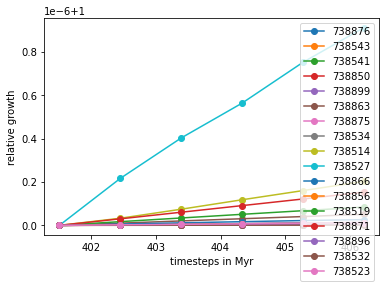

In [234]:
for key in ts_accreted_m.keys():
    plt.plot(timesteps, rel_growth[key], label=key, marker='o')
plt.xlabel('timesteps in Myr')
plt.ylabel('relative growth')
plt.legend()

## Plot the relative growth of the BH that grows the most

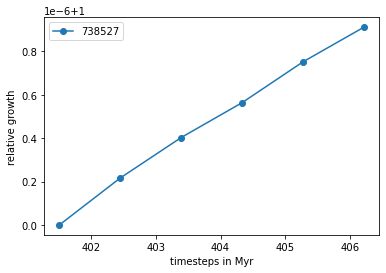

In [238]:
plt.plot(timesteps, rel_growth[most_grown_bh_id], label=most_grown_bh_id, marker='o')
plt.xlabel('timesteps in Myr')
plt.ylabel('relative growth')
plt.legend()

## Plot with Pandas and Altair

In [244]:
import altair as alt
import pandas as pd

In [301]:
rel_growth_str = rel_growth.copy()

In [302]:
for bh_id in rel_growth.keys():
    rel_growth_str[str(bh_id)] = rel_growth_str.pop(bh_id)

In [303]:
rel_growth_str

{'738876': unyt_array([1.        , 1.        , 1.        , 1.00000001, 1.00000001,
             1.00000001], '(dimensionless)'),
 '738543': unyt_array([1., 1., 1., 1., 1., 1.], '(dimensionless)'),
 '738541': unyt_array([1.        , 1.        , 1.        , 1.        , 1.00000001,
             1.00000001], '(dimensionless)'),
 '738850': unyt_array([1.        , 1.        , 1.        , 1.        , 1.00000001,
             1.00000001], '(dimensionless)'),
 '738899': unyt_array([1.        , 1.        , 1.        , 1.        , 1.        ,
             1.00000001], '(dimensionless)'),
 '738863': unyt_array([1.        , 1.00000001, 1.00000002, 1.00000003, 1.00000004,
             1.00000005], '(dimensionless)'),
 '738875': unyt_array([1.        , 1.        , 1.00000001, 1.00000001, 1.00000001,
             1.00000001], '(dimensionless)'),
 '738534': unyt_array([1.        , 1.        , 1.00000001, 1.00000001, 1.00000001,
             1.00000001], '(dimensionless)'),
 '738514': unyt_array([1.    

In [342]:
test_df = pd.DataFrame.from_dict(rel_growth_str)
test_df['Timesteps'] = [time.v for time in timesteps]
test_df = test_df.set_index('Timesteps')

In [341]:
[time.v for time in timesteps]

[array(401.51503415),
 array(402.45391145),
 array(403.39278875),
 array(404.33166605),
 array(405.27054335),
 array(406.20942065)]

In [343]:
test_df

,738876,738543,738541,738850,738899,738863,738875,738534,738514,738527,738866,738856,738519,738871,738896,738532,738523
Timesteps,,,,,,,,,,,,,,,,,
401.5150341488495,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
402.45391144889976,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
403.39278874895,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
404.3316660490002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0
405.27054334905034,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0
406.2094206491006,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [345]:
alt.Chart(test_df).mark_point().encode(
    x='Timesteps:Q',
    y='738876:Q'
)

alt.Chart(...)